In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages
library(maps)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.1.8
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘maps’


The following object is masked from ‘package:purrr’:

    map




[1] "new-york-city-airbnb-open-data"

In [2]:
# Load the Airbnb dataset
airbnb <- read_csv("/kaggle/input/new-york-city-airbnb-open-data/AB_NYC_2019.csv")

Rows: 48895 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (5): name, host_name, neighbourhood_group, neighbourhood, room_type
dbl  (10): id, host_id, latitude, longitude, price, minimum_nights, number_o...
date  (1): last_review

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
# Print the structure of the dataset
str(airbnb)

spc_tbl_ [48,895 × 16] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ id                            : num [1:48895] 2539 2595 3647 3831 5022 ...
 $ name                          : chr [1:48895] "Clean & quiet apt home by the park" "Skylit Midtown Castle" "THE VILLAGE OF HARLEM....NEW YORK !" "Cozy Entire Floor of Brownstone" ...
 $ host_id                       : num [1:48895] 2787 2845 4632 4869 7192 ...
 $ host_name                     : chr [1:48895] "John" "Jennifer" "Elisabeth" "LisaRoxanne" ...
 $ neighbourhood_group           : chr [1:48895] "Brooklyn" "Manhattan" "Manhattan" "Brooklyn" ...
 $ neighbourhood                 : chr [1:48895] "Kensington" "Midtown" "Harlem" "Clinton Hill" ...
 $ latitude                      : num [1:48895] 40.6 40.8 40.8 40.7 40.8 ...
 $ longitude                     : num [1:48895] -74 -74 -73.9 -74 -73.9 ...
 $ room_type                     : chr [1:48895] "Private room" "Entire home/apt" "Private room" "Entire home/apt" ...
 $ price                 

In [4]:
# Print the summary statistics of the dataset
summary(airbnb)

       id               name              host_id           host_name        
 Min.   :    2539   Length:48895       Min.   :     2438   Length:48895      
 1st Qu.: 9471945   Class :character   1st Qu.:  7822033   Class :character  
 Median :19677284   Mode  :character   Median : 30793816   Mode  :character  
 Mean   :19017143                      Mean   : 67620011                     
 3rd Qu.:29152178                      3rd Qu.:107434423                     
 Max.   :36487245                      Max.   :274321313                     
                                                                             
 neighbourhood_group neighbourhood         latitude       longitude     
 Length:48895        Length:48895       Min.   :40.50   Min.   :-74.24  
 Class :character    Class :character   1st Qu.:40.69   1st Qu.:-73.98  
 Mode  :character    Mode  :character   Median :40.72   Median :-73.96  
                                        Mean   :40.73   Mean   :-73.95  
           

Warning message:
“Removed 233 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 9 rows containing missing values (`geom_bar()`).”


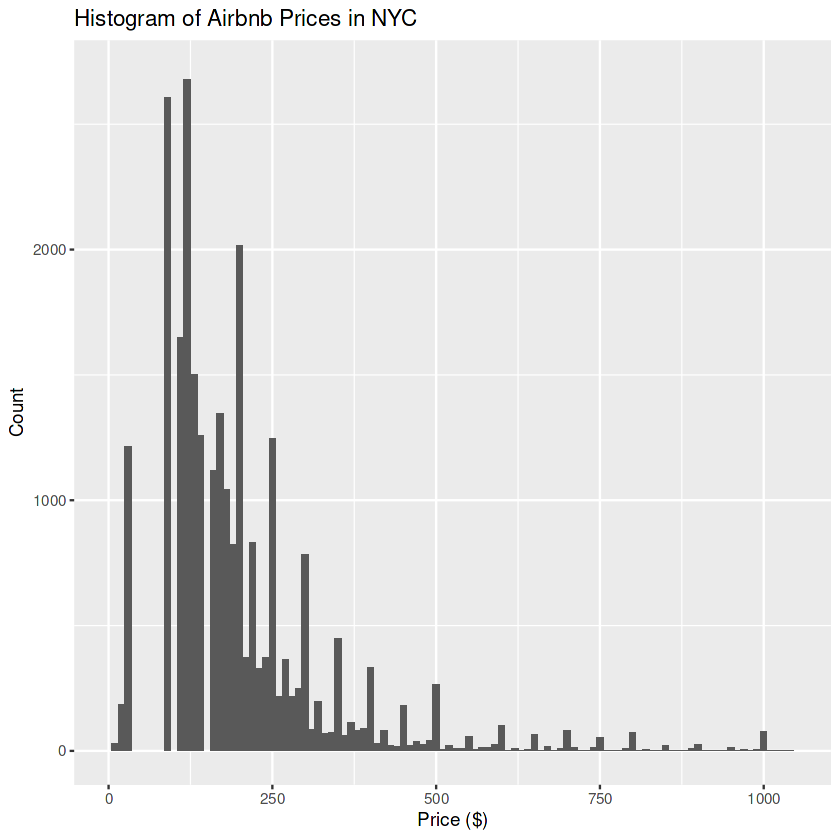

In [5]:
# Create a histogram of the prices
ggplot(data = airbnb, aes(x = price)) + 
    geom_histogram(binwidth = 10) +
    labs(x = "Price ($)", y = "Count", title = "Histogram of Airbnb Prices in NYC") +
    xlim(0, 1050) +
    ylim(0, 2700)

Warning message:
“Removed 45 rows containing missing values (`geom_point()`).”


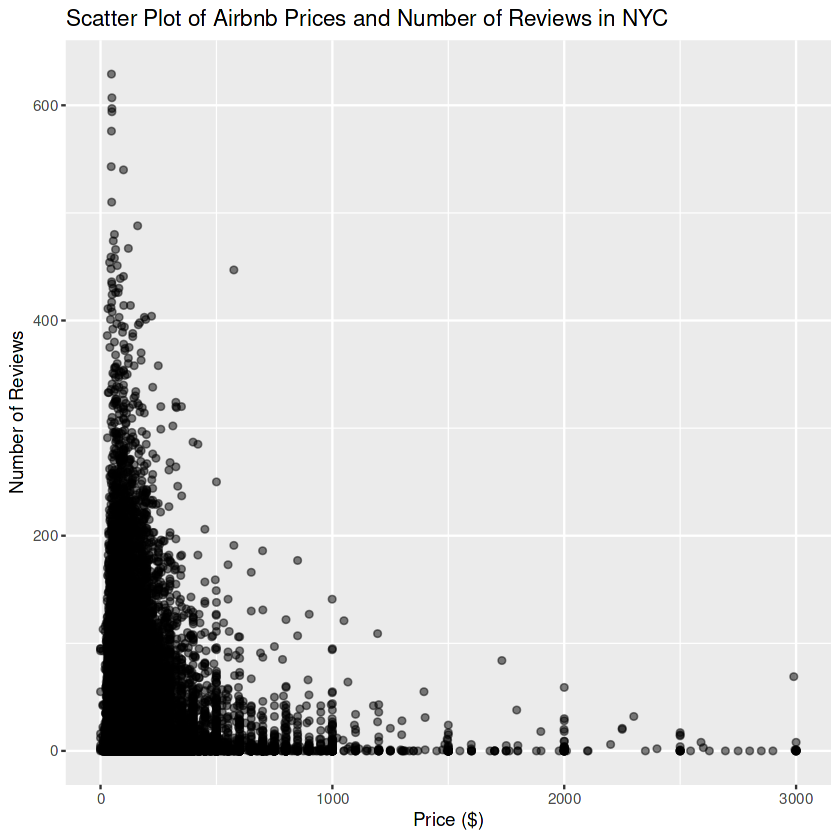

In [6]:
# Create a scatter plot of the prices and number of reviews
ggplot(data = airbnb, aes(x = price, y = number_of_reviews)) +
    geom_point(alpha = 0.5) +
    labs(x = "Price ($)", y = "Number of Reviews", title = "Scatter Plot of Airbnb Prices and Number of Reviews in NYC") + 
    xlim(0, 3000)

Warning message:
“Removed 239 rows containing non-finite values (`stat_boxplot()`).”


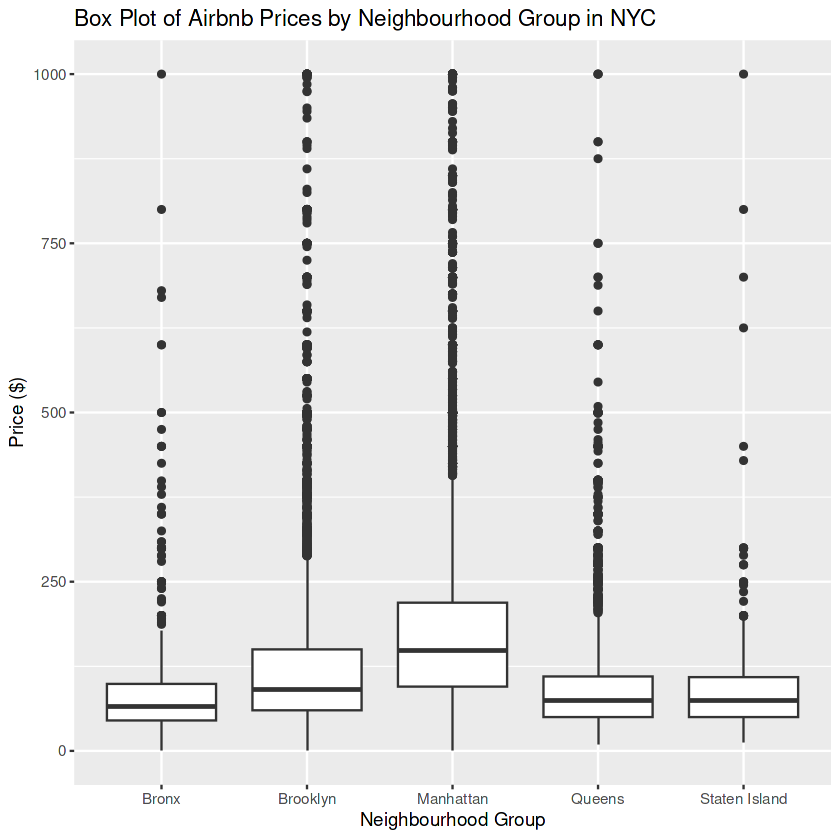

In [7]:
# Create a box plot of the prices by neighborhood group
ggplot(data = airbnb, aes(x = neighbourhood_group, y = price)) +
    geom_boxplot() +
    labs(x = "Neighbourhood Group", y = "Price ($)", title = "Box Plot of Airbnb Prices by Neighbourhood Group in NYC") + 
    ylim(0, 1000)

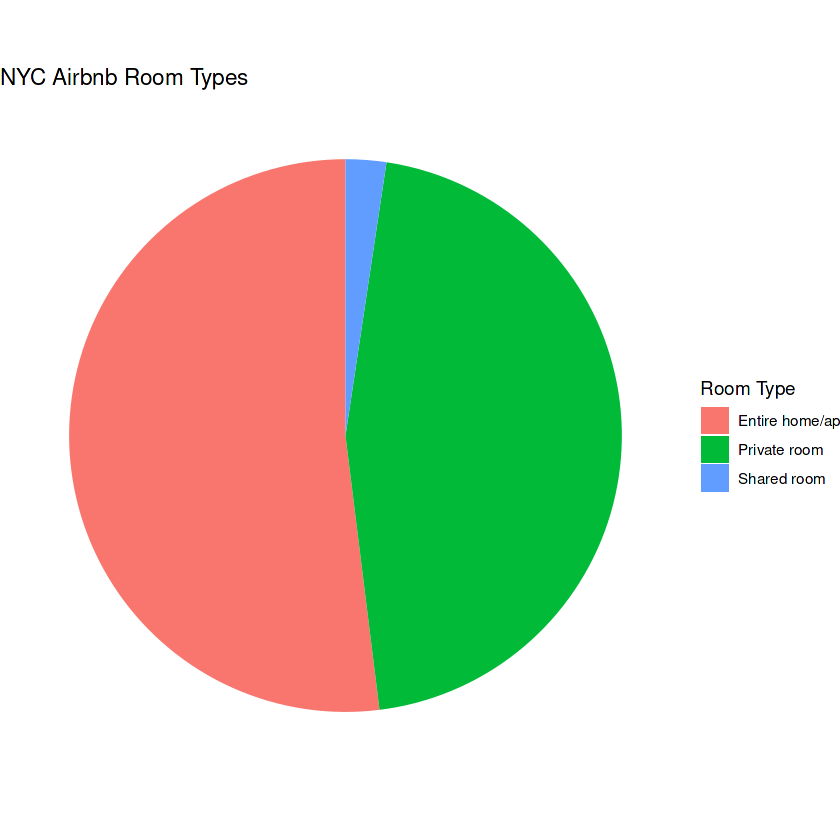

In [9]:
# Create a table of room type counts
room_type_counts <- table(airbnb$room_type)

# Create a data frame from the table
room_type_df <- data.frame(room_type = names(room_type_counts), count = as.numeric(room_type_counts))

# Create a pie chart
pie_chart <- ggplot(room_type_df, aes(x = "", y = count, fill = room_type)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar("y", start = 0) +
  labs(title = "NYC Airbnb Room Types", fill = "Room Type", x = NULL, y = NULL) +
  theme_void()

# Show the pie chart
pie_chart


In [11]:
# Common Map Code

library(ggplot2)
library(ggmap)
library(geosphere)
library(IRdisplay)

# Creating an alias
nyc_airbnb <- airbnb

# Get the center coordinates of the map
ny_center <- c(mean(nyc_airbnb$latitude), mean(nyc_airbnb$longitude))

# Get the bounding box coordinates for the map
ny_bbox  <- c(range(nyc_airbnb$longitude)[1], range(nyc_airbnb$latitude)[1],
             range(nyc_airbnb$longitude)[2], range(nyc_airbnb$latitude)[2])

# Get the map of New York City
ny_map <- get_stamenmap(ny_bbox, zoom = 12, maptype = "toner-lite")

# Create a ggmap object with the New York City map
ny_ggmap <- ggmap(ny_map)

ℹ Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.

ℹ 49 tiles needed, this may take a while (try a smaller zoom?)



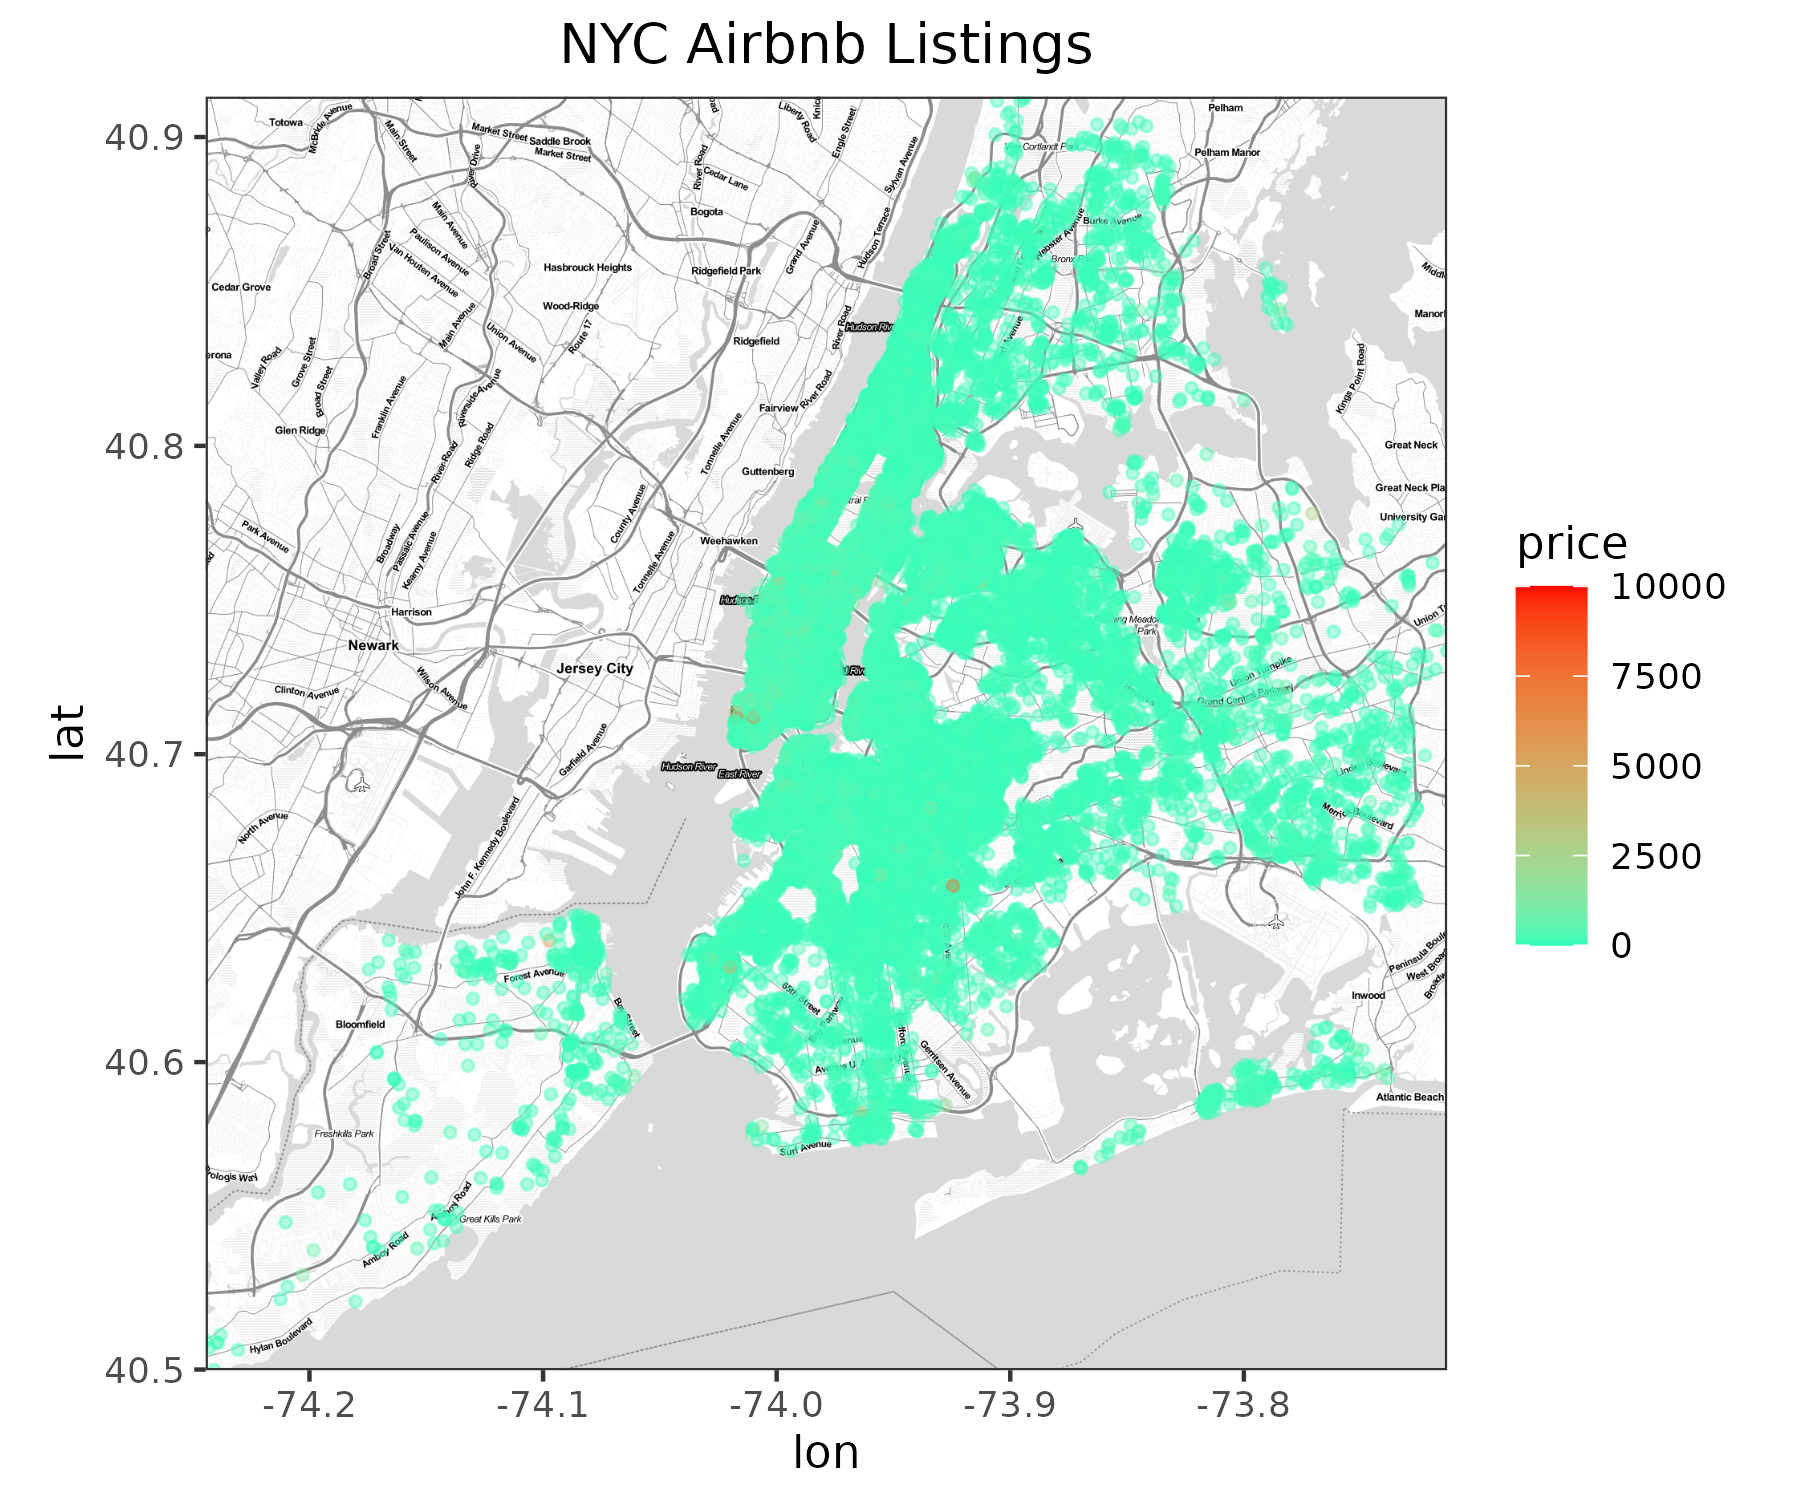

In [12]:
# Plot the map with the Airbnb listings to 
nyc_map_plot <- ny_ggmap +
  geom_point(data = nyc_airbnb, aes(x = longitude, y = latitude, color = price),
             alpha = 0.4, size = 1) +
  scale_color_gradient(low = "#33FDBB", high = "red") +
  ggtitle("NYC Airbnb Listings") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5))

ggsave("nyc_airbnb_map_by_price.png", plot = nyc_map_plot, width = 6, height = 5)

# Display the saved plot in the notebook
display_png(file = "nyc_airbnb_map_by_price.png")

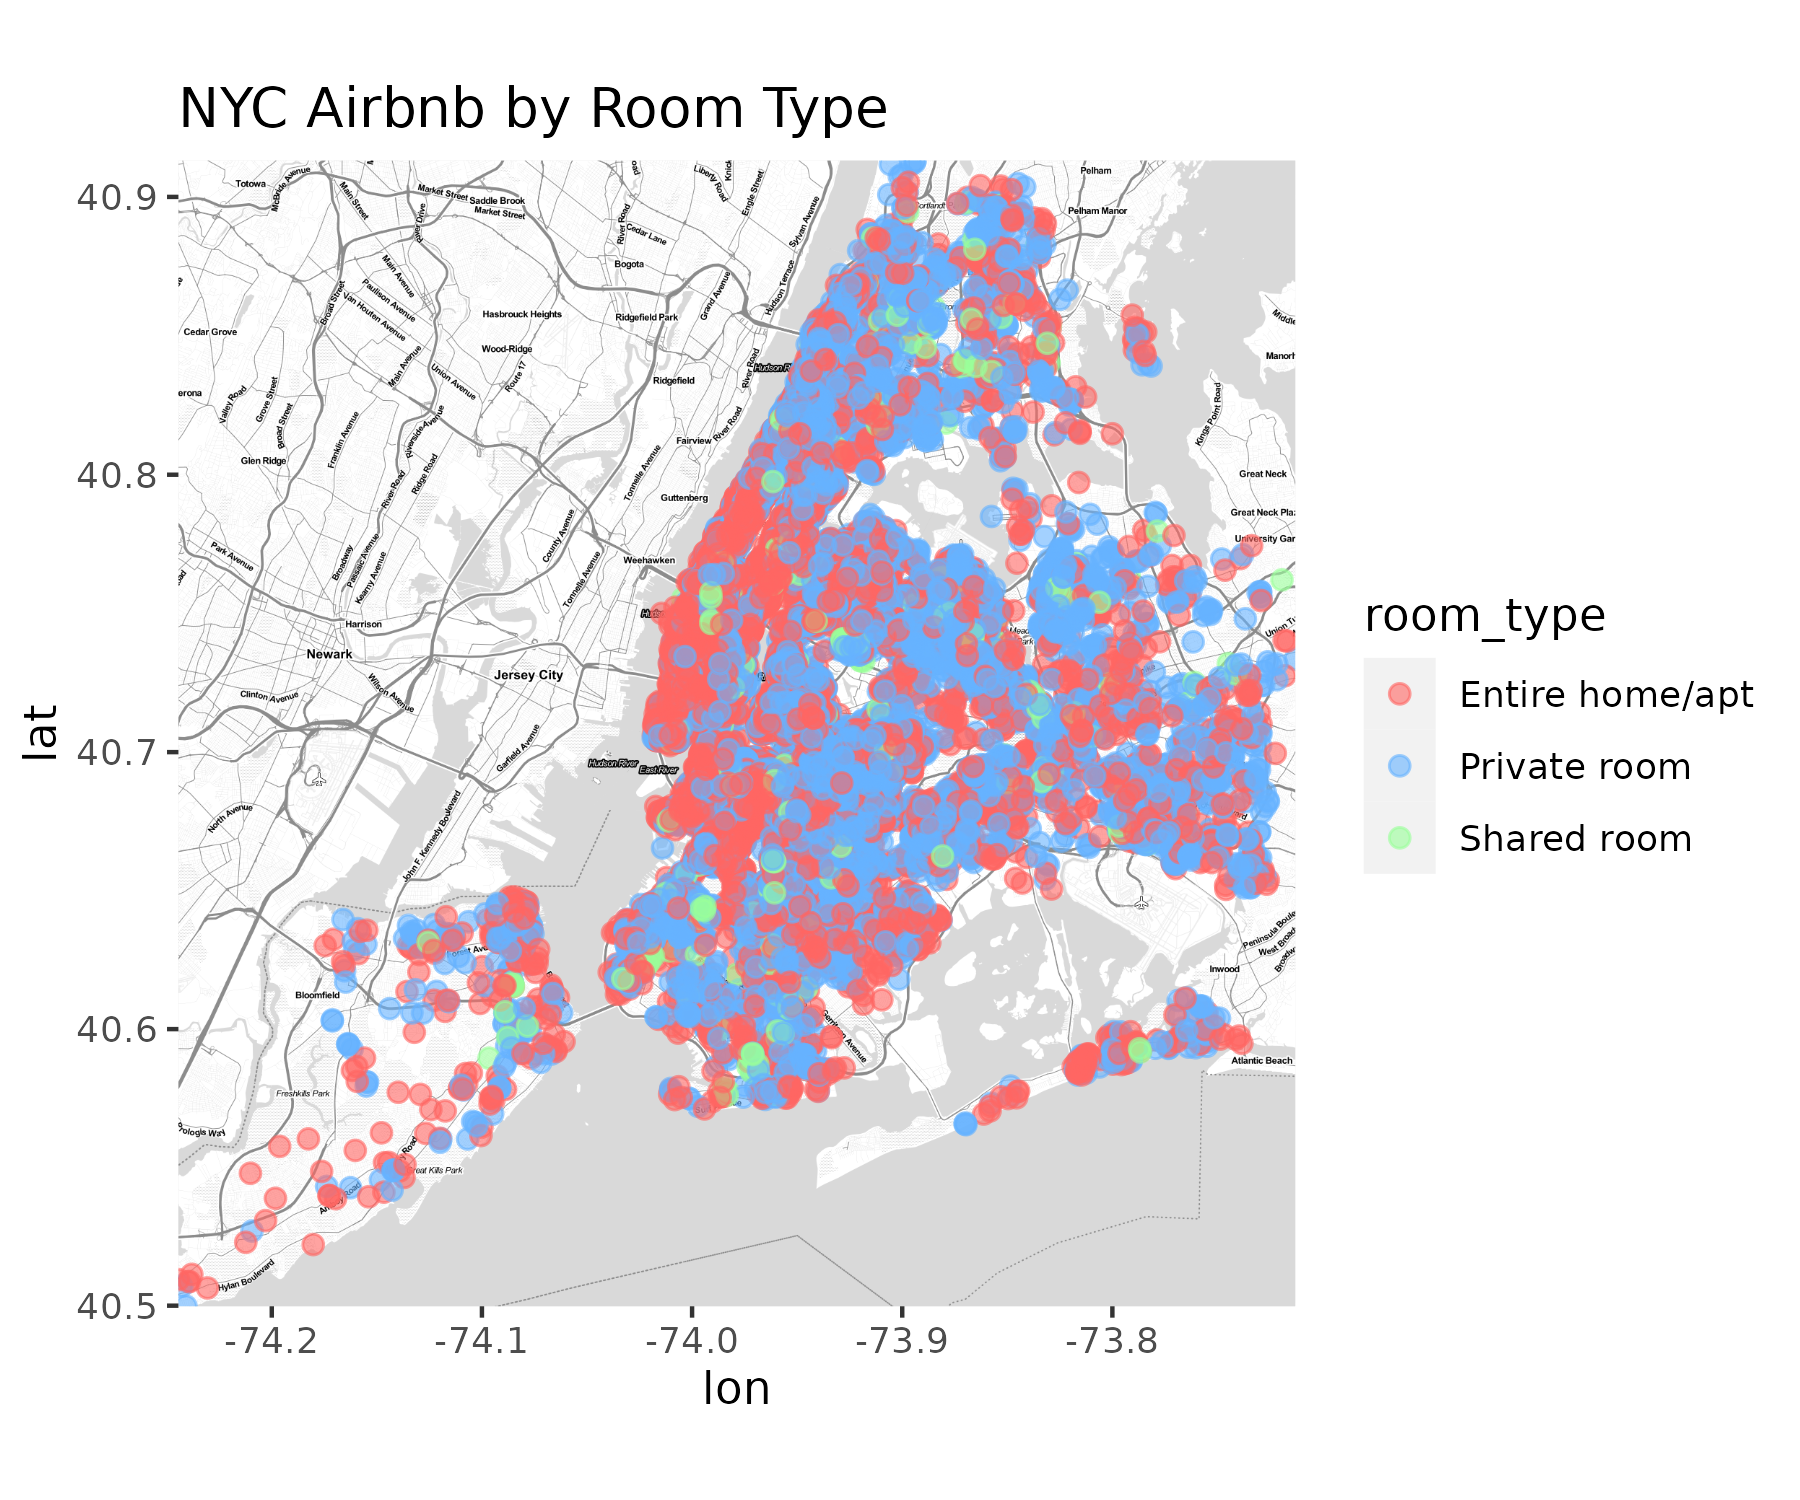

In [13]:
# Overlay points on the map and color them by room type
nyc_airbnb_map <- ny_ggmap +
  geom_point(data = nyc_airbnb, aes(x = longitude, y = latitude, color = room_type), 
             alpha = 0.6, size = 2) +
  scale_color_manual(values = c("#FF6663", "#66B3FF", "#99FF99")) +
  labs(title = "NYC Airbnb by Room Type")

ggsave("nyc_airbnb_map_by_type.png", plot = nyc_airbnb_map, width = 6, height = 5)

# Display the saved plot in the notebook
display_png(file = "nyc_airbnb_map_by_type.png")

In [ ]:
# https://www.kaggle.com/code/rohan843/chs-data-visualization-with-r/